In [1]:
import math
import requests
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from requests.exceptions import ConnectionError

# Modelo 5

Igual que el 3 sin **EMBARAZO**

In [2]:
try:
    from pyspark.sql import SparkSession
except:
    import findspark
    findspark.init()
    from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.appName("COVID") \
        .config("hive.exec.dynamic.partition", "true")\
        .config("hive.exec.dynamic.partition.mode", "nonstrict") \
        .enableHiveSupport()\
        .getOrCreate()

sc=spark.sparkContext

In [4]:
def filtraPositivos(df):
    """
    Esta función filtra los casos positivos de un DataFrame dado.
    df: spark DataFrame con la columna 'resultado'
    """
    #Devolvemos nuestro df con los casos positivos
    return df.filter(df.RESULTADO == 'Positivo SARS-CoV-2')

In [5]:
def limpiaNulls(df):
    """
    Función que limpia nulls en un DF de spark e imprime
    la cantidad de registros que borró (cantidad de valores
    nulos).
    """
    cleanDF = df.na.drop()
    
    print("Numero de registros con algun valor nulo: ", df.count() - cleanDF.count())
    return cleanDF

#### Cargamos nuestros datos

In [6]:
#path del archivo csv
file_local_path = 'C:/Users/nieto/Desktop/casos-asociados-a-covid-19.csv'

#cargamos el archivo en un spark DataFrame
df_origen = spark.read.csv(file_local_path, header=True, encoding='UTF-8', inferSchema=True)

#covariables que vamos a tomar en cuenta para el modelo
features = ["TIPO PACIENTE", "SEXO", "EDAD", "DIABETES", "EPOC", "ASMA", "INMUNOSUPRESION", "HIPERTENSION","EMBARAZO",
            "OTRA COMPLICACION", "CARDIOVASCULAR", "OBESIDAD", "RENAL CRONICA", "TABAQUISMO","RESULTADO"]
features.remove("EMBARAZO")
features.remove("OTRA COMPLICACION")
features.remove("TABAQUISMO")
features.remove("OBESIDAD")
features.remove("ASMA")


df = df_origen.select(features)

#filtramos los casos positivos
df = filtraPositivos(df)
#ya no necesitamos la columna resultado
df = df.drop('RESULTADO')
#limpiamos nuestra información
df = limpiaNulls(df)
#creamos una vista temporal en spark
df.createOrReplaceTempView('covid')

Numero de registros con algun valor nulo:  0


In [7]:
#cargamos lo que necesitamos de spark.ml
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, MinMaxScaler, ChiSqSelector

#### Procesamiento de datos de entrenamiento

In [8]:
def dataProcessing(train, categoricalCols, numericalCols, labelCol="TIPO PACIENTE"):
    """Función que hace todo el preprocesamiento de los datos
    categóricos de un conjunto de datos de entrenamiento (o no).
    :param train spark df: conjunto de datos de entrenamiento.
    :param categoricalCols list,array: conjunto de nombres de columnas categoricas del
        conjunto de datos train.
    :param numericalCols list,array: conjunto de nombres de columnas numéricas del 
        conjunto de datos train.
    :param labelCol str: variable objetivo o etiqueta
    
    :Returns spark dataframe con las columnas 'label' y 'features'
    """
    
    #codificamos todas las variables categóricas
    stages = []
    for categoricalCol in categoricalCols:
        stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol= categoricalCol + "Index")
        encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()],
                                        outputCols=[categoricalCol + "ohe"])
        stages += [stringIndexer, encoder]

    #variable objetivo (etiqueta)
    label_strIdx = StringIndexer(inputCol=labelCol, outputCol="label")
    stages += [label_strIdx]

    #ponemos todas las covariables en un vector
    assemblerInputs = [c + "ohe" for c in categoricalCols] + numericalCols
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="feat")
    stages += [assembler]
    
    #seleccionamos las variables que nos sirven con ChiSqSelector
    selector = ChiSqSelector(featuresCol="feat", outputCol="feature", labelCol="label", fpr=0.05,
                            selectorType='fpr')
    stages += [selector]
    
    #escala de 0-1
    scala = MinMaxScaler(inputCol="feature", outputCol="features")
    stages += [scala]
    
    #pipeline donde vamos a hacer todo el proceso
    pipe = Pipeline(stages=stages)
    pipeModel = pipe.fit(train)
    train = pipeModel.transform(train)
    
    #regresamos nuestro df con lo que necesitamos
    return train

In [9]:
#parámetros necesarios para procesamiento de datos
categoricalCols = list(df.columns[1:])
categoricalCols.remove("EDAD")
numericalCols = ["EDAD"]

#con dataProcessing() procesamos toda nuestra data
raw_data = dataProcessing(df, categoricalCols, numericalCols, labelCol="TIPO PACIENTE")

In [10]:
#separamos nuestros datos en conjunto de entrenamiento y prueba
train, test = raw_data.randomSplit([0.70,0.30])

In [11]:
train.select("label","features").show(5,truncate=False)

+-----+---------------------------------------------------------+
|label|features                                                 |
+-----+---------------------------------------------------------+
|0.0  |[1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0]|
|0.0  |[1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0]|
|0.0  |[1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0]|
|0.0  |[1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0]|
|0.0  |[1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0]|
+-----+---------------------------------------------------------+
only showing top 5 rows



In [12]:
numHosp = train.filter(df["TIPO PACIENTE"]=="HOSPITALIZADO").count()
numAmb = train.filter(df["TIPO PACIENTE"]=="AMBULATORIO").count()

#BalancingRatio nos ayuda a darle más peso a la clase minoritaria
BalancingRatio = numAmb / (numHosp + numAmb)
print("Balancing Ratio: ", BalancingRatio)

Balancing Ratio:  0.6584275713516424


In [13]:
from pyspark.sql.functions import when

train=train.withColumn("classWeights", when(train.label == 1,BalancingRatio).otherwise(1-BalancingRatio))
train.select("classWeights").show(5)

+------------------+
|      classWeights|
+------------------+
|0.3415724286483576|
|0.3415724286483576|
|0.3415724286483576|
|0.3415724286483576|
|0.3415724286483576|
+------------------+
only showing top 5 rows



#### Entrenamiento del modelo

In [14]:
def modeloLogistico(data, labelCol="label", featuresCol="features", weightCol=""):
    """
    Función que se encarga de ajustar un modelo logístico
    a partir de un dataframe de spark con el esquema ya procesado
    a partir de la función dataProcessing().
    
    :param data: spark dataframe.
    :param labelCol: string nombre de la columna con la variable respuesta.
    :param featuresCol: string nombre de la columna con los vectores de las
        covariables.
    
    :returns modelo ajustado:
    """
    from pyspark.ml.classification import LogisticRegression
    
    model = LogisticRegression(featuresCol=featuresCol, labelCol=labelCol, weightCol=weightCol)
    return model.fit(data)

In [15]:
#Entrenamos nuestro modelo con el conjunto de entrenamiento y la función modeloLogistico()
model = modeloLogistico(data=train, labelCol="label", featuresCol="features", weightCol="classWeights")

In [16]:
print("Coeficientes: ",str(model.coefficientMatrix))
print("Intercepto: ", str(model.interceptVector))

Coeficientes:  DenseMatrix([[ 0.53382336, -0.43930703,  0.26546794,  0.48339243,  0.83662783,
               0.01379904,  0.84166765, -0.2731102 , -0.01108693, -0.24478737,
              -0.20437965, -0.04214644,  0.8762505 ,  5.74893507]])
Intercepto:  [-2.3553914751024663]


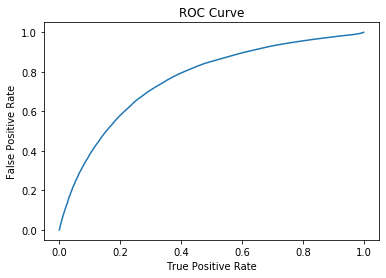

Training set areaUnderROC: 0.7618166532733097


In [17]:
modelSummary = model.summary

roc = modelSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(modelSummary.areaUnderROC))

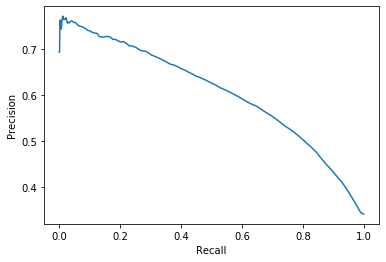

In [18]:
#Presición vs Exhaustividad (recall)
pr = modelSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

#### Predicciones

In [19]:
def predictLogistico(test,categoricalCols, numericalCols, labelCol, model):
#     dataProcessing(train, categoricalCols, numericalCols, labelCol="TIPO PACIENTE")
    """
    Esta función predice un modelo logístico con columnas categóricas
    y numéricas sobre un conjunto de datos de prueba.
    """
    predictions = model.transform(test)
    #regresamos el df con las predicciones
    return predictions

In [20]:
#hacemos nuestras predicciones aplicándole el modelo a nuestro conjunto de prueba
pred = model.transform(test)

In [21]:
#Matriz de confusión
#índice: etiqueta real
#columnas: predicción de nuestro modelo
pred.crosstab("label","prediction").show()

+----------------+-----+----+
|label_prediction|  0.0| 1.0|
+----------------+-----+----+
|             1.0| 3529|7279|
|             0.0|15043|5549|
+----------------+-----+----+



In [22]:
#AUROC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print("Exactitud del modelo: ", modelSummary.accuracy)
print('Training set Area Under ROC: ' + str(modelSummary.areaUnderROC))
print('Test set Area Under ROC', evaluator.evaluate(pred))

Exactitud del modelo:  0.7104738826063544
Training set Area Under ROC: 0.7618166532733097
Test set Area Under ROC 0.7588274024478691


In [23]:
#otras métricas de evaluación
print("clases:", modelSummary.labels)
print("f-measure",modelSummary.fMeasureByLabel(beta=1.0))
print("false-positive rate by label:", modelSummary.falsePositiveRateByLabel)
print("Precisión: ", modelSummary.precisionByLabel)
print("Exhaustividad (recall): ", modelSummary.recallByLabel)

clases: [0.0, 1.0]
f-measure [0.7679091752822085, 0.6152635156892912]
false-positive rate by label: [0.32224499448210625, 0.2725525476404678]
Precisión:  [0.8131370846094071, 0.563323068859333]
Exhaustividad (recall):  [0.7274474523595322, 0.6777550055178937]


## Conclusión:

El modelo mejora significativamente poniendole la variable de **NEUMONIA** pero esta columna no se debe de agregar al modelo ya que esto es una consecuencia del COVID-19 y no un padecimiento que se haya tenido anteriormente a contraer la enfermedad.

In [24]:
df.groupby("NEUMONIA").pivot("TIPO PACIENTE").count().show()

AnalysisException: "cannot resolve '`NEUMONIA`' given input columns: [SEXO, EPOC, INMUNOSUPRESION, HIPERTENSION, CARDIOVASCULAR, EDAD, RENAL CRONICA, DIABETES, TIPO PACIENTE];;\n'Pivot ArrayBuffer('NEUMONIA), TIPO PACIENTE#18: string, [AMBULATORIO, HOSPITALIZADO], [count(1)]\n+- Filter AtLeastNNulls(n, TIPO PACIENTE#18,SEXO#14,EDAD#24,DIABETES#28,EPOC#29,INMUNOSUPRESION#31,HIPERTENSION#32,CARDIOVASCULAR#34,RENAL CRONICA#36)\n   +- Project [TIPO PACIENTE#18, SEXO#14, EDAD#24, DIABETES#28, EPOC#29, INMUNOSUPRESION#31, HIPERTENSION#32, CARDIOVASCULAR#34, RENAL CRONICA#36]\n      +- Filter (RESULTADO#39 = Positivo SARS-CoV-2)\n         +- Project [TIPO PACIENTE#18, SEXO#14, EDAD#24, DIABETES#28, EPOC#29, INMUNOSUPRESION#31, HIPERTENSION#32, CARDIOVASCULAR#34, RENAL CRONICA#36, RESULTADO#39]\n            +- Relation[FECHA ACTUALIZACION#10,ORIGEN#11,SECTOR#12,ENTIDAD UNIDAD MEDICA#13,SEXO#14,ENTIDAD NACIMIENTO#15,ENTIDAD RESIDENCIA#16,MUNICIPIO RESIDENCIA#17,TIPO PACIENTE#18,FECHA INGRESO#19,FECHA SINTOMAS#20,FECHA DEFUNCION#21,INTUBADO#22,NEUMONIA#23,EDAD#24,NACIONALIDAD#25,EMBARAZO#26,HABLA LENGUA INDIGENA#27,DIABETES#28,EPOC#29,ASMA#30,INMUNOSUPRESION#31,HIPERTENSION#32,OTRA COMPLICACION#33,... 16 more fields] csv\n"